In [1]:
"""
Demo to show Logistic Regression (classification) 

Demo v1.0
Author: Hariyanto Lim
Last update: 2024-07-18
"""
# interactive mode for Jupyter notebbok in browser (not in command line)
# require: pip install ipympl
#%matplotlib widget
import matplotlib.pylab as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay

import pickle # to save/load model to/from file


In [2]:
def save_model(model, filename):
    print('### save_model()')

    # save the model to disk
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename):

    try:
        # load both model
        model = pickle.load(open(filename, 'rb'))

        print(f"### load_model(): '{filename}' loaded")

        return model

    except FileNotFoundError:
        print(f"### load_model(): error '{filename}' not found")

    return None

def load_csv_into_dataframe(csv_filename):
    try:
        df = pd.read_csv(csv_filename)

        return df

    except FileNotFoundError:
        print(f"*** load_csv_into_dataframe(): '{csv_filename}' not found")

    return None

In [10]:
def predict_data(model, X, y):
    # predict
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)[:, 1]
    
    """
    LEARNING POINT: after predict then check the accuracy
    """
    # Evaluate the model
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_prob)
    conf_matrix = confusion_matrix(y, y_pred)
    class_report = classification_report(y, y_pred)

    # Print the evaluation metrics
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'ROC-AUC: {roc_auc:.2f}')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)

    visualize_confusion_matrix(model, conf_matrix)
    visualize_roc_curve(roc_auc, y, y_pred_prob)
    
def create_model(df):
    """
    Main job: create model from DataFrame    
    """

    print(f"### create_model(DataFrame)")

    # define X ==> data to train (independent) and y ==> the target (dependent, annotated)
    X = df.drop(df.columns[-1], axis=1) # df.columns[-1] == the most right side column
    y = df.take([-1], axis=1)

    """
    Optional check: data to learn (X) should be numerical (int or float), there should NOT be any blank, text, or symbol.    
    """
    numeric_df = df.apply(pd.to_numeric, errors='coerce')
    is_all_numeric = not numeric_df.isnull().values.any()
    if is_all_numeric == False:
        print(f"*** ERROR: the data content of CSV to be used as training model has non-numeric value, please fix this!")
        print(df)
        return None
    
    """
    LEARNING POINT: A common exercise to split the input data for training and for testing,
    Reasons:
    1. To evaluate the model we should not use data from other source,
       we only trust all data points from this same source.
    2. To create unseen data to get performance of the model using unseen data later.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the logistic regression model
    model = LogisticRegression(max_iter=1000)
    # with only values (exclude header text)
    model.fit(X_train.values, y_train.values)

    print(f"Logistic Regression model is created")

    # show the coefficient and intercept value
    print(f"***\nCoefficients = {model.coef_}\nIntercept = {model.intercept_}\n***")

    """
    LEARNING POINT: After model is created, it is time to use the model to predict the same trained data
    Reasons:
    1. Model assessment, predicting on the training data allows us
       to assess how well the model fits the training data.
    2. Debugging and understanding, Examining the predictions on the training data
       can help in debugging the model and understanding its behavior.
       By comparing the predicted values with the actual values in the training set,
       we can identify potential issues such as underfitting, overfitting, or data preprocessing errors.
       IF we found problem THEN we can try to update the model
    """
    print(f"\n***** Evaluate the model using the same TRAINED data *****")
    predict_data(model, X_train.values, y_train.values)

    """
    LEARNING POINT: After model assessment is done and the performance is accepted,
    then predict the unseen testing data.
    Reasons:
    1. Model evaluation, create unseen data to get performance of the model using unseen data later.
    2. Prevent overfitting, to check if the model is effective only on trained data but not on unseen data.    
    """
    print(f"\n***** Evaluate model using UNSEEN TESTING data *****")
    predict_data(model, X_test.values, y_test.values)

    return model

def visualize_data(df):

    # Histograms of Features,
    # total 14 columns, remove the last column (it is dependend variable)
    numerical_features = ['Age', 'Sex', 'CP', 'Trestbps', 'Chol', 'FBS', 'Restecg', 'Thalach', 'Exang', 'Oldpeak', 'Slope', 'Ca', 'Thal']

    # error: ValueError: num must be an integer with 1 <= num <= 6, not 7

    # limit to maximum only 6 Features
    numerical_features = ['Age', 'Sex', 'Trestbps', 'Chol', 'Thalach', 'Oldpeak']

    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(numerical_features):
        plt.subplot(2, 3, i+1)
        plt.hist(df[feature], bins=20, edgecolor='k')
        plt.title(f'{feature} Distribution')
        plt.xlabel(feature)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def visualize_correlation_matrix(df):
    # Correlation Matrix, to display all Features including Target
    corr_matrix = df.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()

def visualize_roc_curve(roc_auc, y, y_predicted):
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y, y_predicted)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def visualize_confusion_matrix(model, conf_matrix):
    # Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

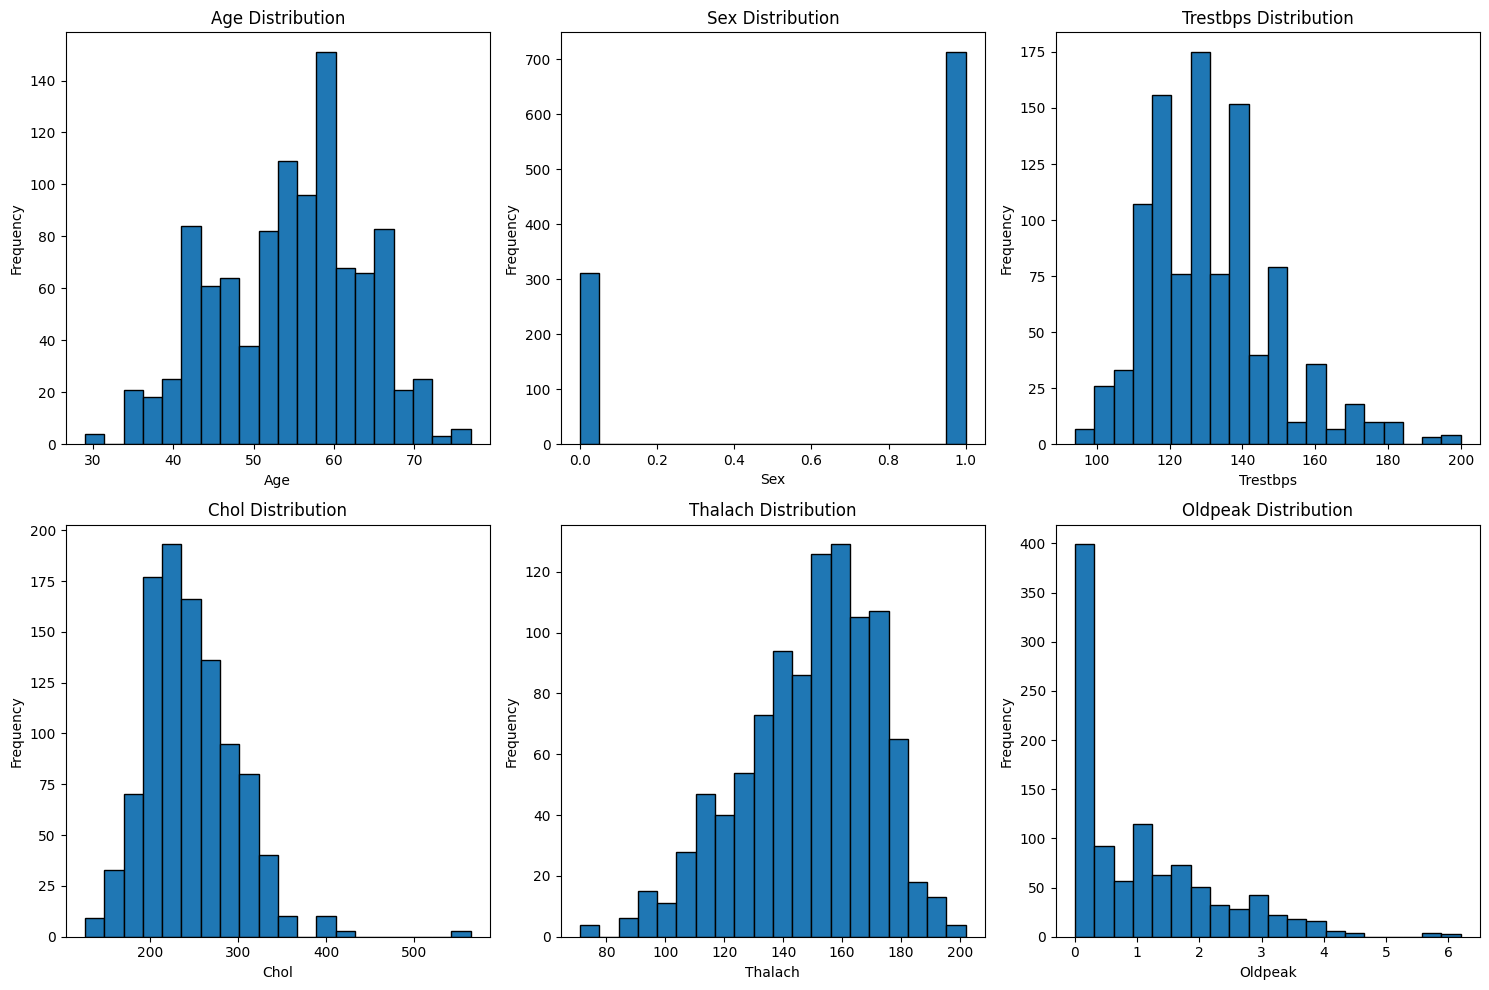

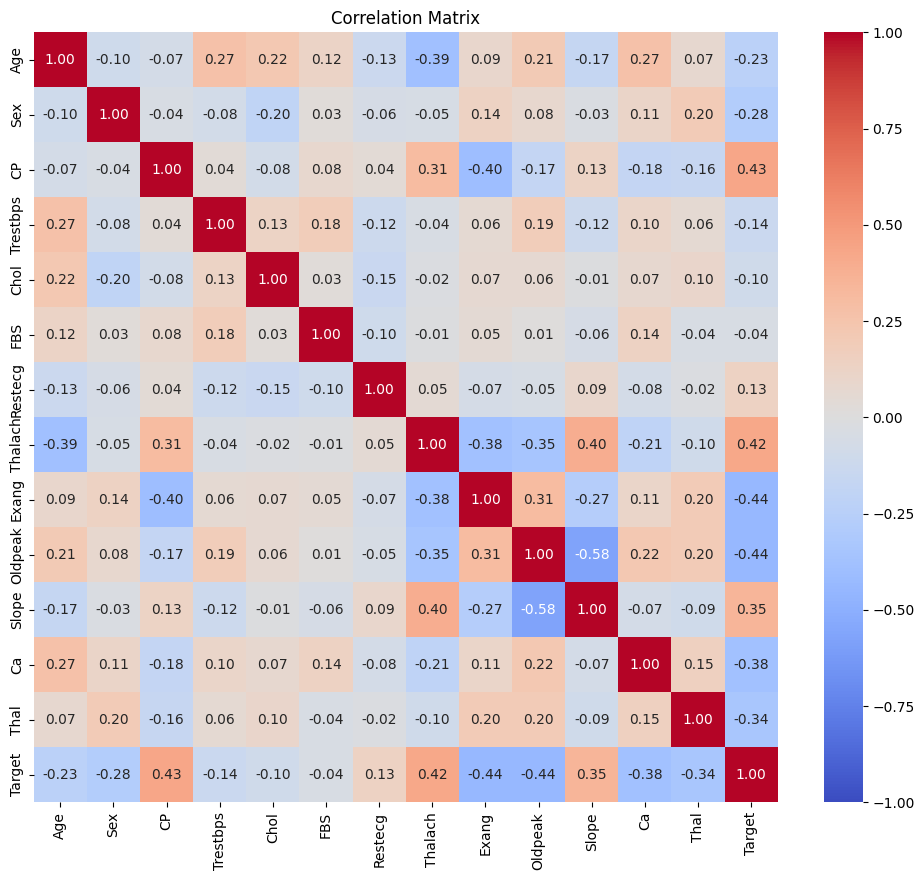

In [11]:
input_filename = "heart-disease-from-kaggle-johnsmith88.csv"
df = load_csv_into_dataframe(input_filename)
if df is None:
    print(f"load csv '{input_filename}' failed")
    exit(-3)

#print(df)

#visualizeIn3D(df)
visualize_data(df)
visualize_correlation_matrix(df)